In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def nrcs_swe_api_pull(station_id, start_date, end_date):
    "API Reference: https://wcc.sc.egov.usda.gov/awdbRestApi/swagger-ui/index.html#/Data/getData"
    
    url = f"""https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data?
    stationTriplets={station_id}%3ACO%3ASNTL&elements=%2A&duration=DAILY
    &beginDate={start_date}&endDate={end_date}&periodRef=END&centralTendencyType=ALL
    &returnFlags=false&returnOriginalValues=false&returnSuspectData=false"""
    
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data)
    df_flat = pd.json_normalize(df['data'][0])

    expanded_values = []
    for i, row in df_flat.iterrows():
        for value_entry in row['values']:
            expanded_values.append({
                'date': value_entry.get('date'),
                'elementCode': row.get('stationElement.elementCode'),
                'value': value_entry.get('value', 0),
                'average': value_entry.get('average', 0),
                'median': value_entry.get('median', 0),
                'unit': row.get('stationElement.storedUnitCode')
            })
    df = pd.DataFrame(expanded_values)
    df['date'] = pd.to_datetime(df['date'])
    df = df.convert_dtypes()
    print(df.info())       
    return df

In [ ]:
# Pull Data
station_345_bison_lake_swe = nrcs_swe_api_pull('345', '2000-01-01', '2024-09-06')
station_345_bison_lake_swe['Station'] = 'Bison Lake'
station_618_mcclure_pass_swe = nrcs_swe_api_pull('618', '2000-01-01', '2024-09-06')
station_618_mcclure_pass_swe['Station'] = 'McClure Pass'

df = pd.concat([station_345_bison_lake_swe, station_618_mcclure_pass_swe])

In [5]:
# Pivot by Element Code
df_pivot = df.pivot_table(
    values='value', 
    index=['date','Station'], 
    columns='elementCode'
)
df_pivot = df_pivot.reset_index().rename_axis(None, axis=1)
df_pivot

,date,Station,PRCP,PRCPMTD,PRCPSA,PREC,SNDN,SNRR,SNWD,TAVG,TMAX,TMIN,TOBS,WTEQ
0,1980-07-12,Station 618 - McClure Pass,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,54.1,<NA>
1,1980-07-13,Station 618 - McClure Pass,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,55.4,<NA>
2,1980-07-14,Station 618 - McClure Pass,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,48.2,<NA>
3,1980-07-15,Station 618 - McClure Pass,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,50.5,<NA>
4,1980-07-16,Station 618 - McClure Pass,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,53.6,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30345,2024-09-04,Station 618 - McClure Pass,0.0,0.0,0.0,32.4,<NA>,<NA>,0.0,54.0,68.0,44.6,45.0,<NA>
30346,2024-09-05,Station 345 - Bison Lake,0.0,0.2,0.0,37.1,<NA>,<NA>,0.0,43.7,55.0,35.2,38.8,0.0
30347,2024-09-05,Station 618 - McClure Pass,0.0,0.0,0.0,32.4,<NA>,<NA>,0.0,52.0,65.5,42.1,46.2,<NA>
30348,2024-09-06,Station 345 - Bison Lake,<NA>,0.1,<NA>,37.0,<NA>,<NA>,<NA>,48.2,59.5,35.8,43.2,<NA>


### Element Descriptions
| Name                                                   | Element Code | Unit       |
| :----------------------------------------------------- | :----------- | :--------- |
| AIR TEMPERATURE AVERAGE                                | TAVG         | Fahrenheit |
| AIR TEMPERATURE MAXIMUM                                | TMAX         | Fahrenheit |
| AIR TEMPERATURE MINIMUM                                | TMIN         | Fahrenheit |
| AIR TEMPERATURE OBSERVED                               | TOBS         | Fahrenheit |
| DIVERSION FLOW VOLUME OBSERVED                         | DIV          | acre-feet  |
| DIVERSION DISCHARGE OBSERVED MEAN                      | DIVD         | cfs        |
| DISCHARGE MANUAL/EXTERNAL ADJUSTED MEAN                | SRDOX        | cfs        |
| PRECIPITATION ACCUMULATION                             | PREC         | inches     |
| PRECIPITATION INCREMENT                                | PRCP         | inches     |
| PRECIPITATION INCREMENT â€“ SNOW-ADJUSTED              | PRCPSA       | inches     |
| RESERVOIR STORAGE VOLUME                               | RESC         | acre-feet  |
| RIVER DISCHARGE OBSERVED MEAN                          | SRDOO        | cfs        |
| SNOW DEPTH                                             | SNWD         | inches     |
| SNOW WATER EQUIVALENT                                  | WTEQ         | inches     |
| STREAM VOLUME, ADJUSTED                                | SRVO         | acre-feet  |
| STREAM VOLUME, ADJUSTED EXTERNALLY                     | SRVOX        | acre-feet  |
| STREAM VOLUME, OBSERVED                                | SRVO         | acre-feet  |
| TELECONNECTION INDEX (also known as OSCILLATION INDEX) | OI           | N/A        |

In [6]:
selected_columns = ['date', 'Station', 'SNWD', 'WTEQ', 'PREC', 'PRCP', 'TAVG', 'TMAX', 'TMIN']
df_final = df_pivot[selected_columns].dropna()
df_final

,date,Station,SNWD,WTEQ,PREC,PRCP,TAVG,TMAX,TMIN
10552,1997-08-01,Station 345 - Bison Lake,0.0,0.0,48.2,0.0,50.5,63.3,41.2
10554,1997-08-02,Station 345 - Bison Lake,0.0,0.0,48.2,0.0,55.0,66.4,45.1
10556,1997-08-03,Station 345 - Bison Lake,0.0,0.0,48.5,0.3,54.9,71.1,45.3
10558,1997-08-04,Station 345 - Bison Lake,0.0,0.0,48.6,0.1,50.0,62.1,44.2
10560,1997-08-05,Station 345 - Bison Lake,0.0,0.0,48.8,0.2,46.0,50.5,42.3
...,...,...,...,...,...,...,...,...,...
30341,2024-09-02,Station 618 - McClure Pass,0.0,0.0,32.4,0.0,58.1,71.8,46.2
30342,2024-09-03,Station 345 - Bison Lake,0.0,0.0,36.9,0.0,52.3,62.1,43.7
30343,2024-09-03,Station 618 - McClure Pass,0.0,0.0,32.4,0.0,59.0,72.7,47.8
30344,2024-09-04,Station 345 - Bison Lake,0.0,0.0,37.1,0.2,45.5,57.2,35.2


In [3]:
# df_final.to_parquet('data/nrcs_snow_water_equivalent_and_temp.parquet', index=False)
df_final = pd.read_parquet('data/nrcs_snow_water_equivalent_and_temp.parquet')

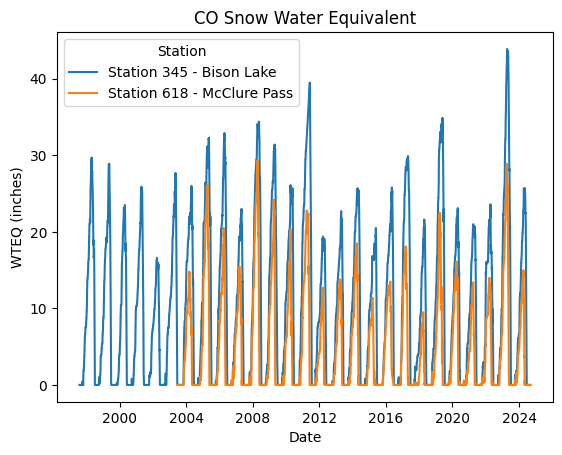

In [4]:
# Visualize SWEQ
sns.lineplot(data=df_final, x='date', y='WTEQ', hue='Station', legend=True)
plt.title('CO Snow Water Equivalent')
plt.xlabel('Date')
plt.ylabel('WTEQ (inches)')
plt.show()

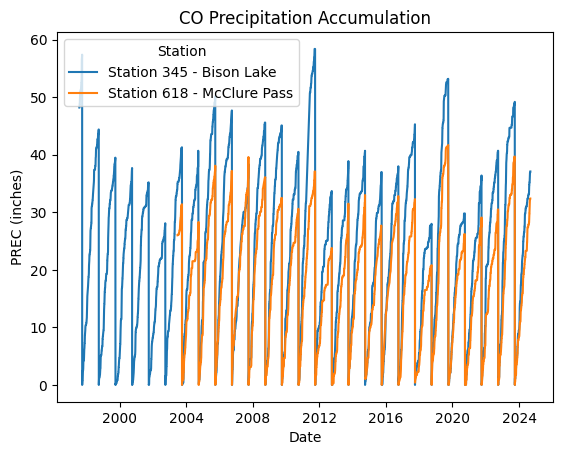

In [5]:
# Visualize Precipitation
sns.lineplot(data=df_final, x='date', y='PREC', hue='Station', legend=True)
plt.title('CO Precipitation Accumulation')
plt.xlabel('Date')
plt.ylabel('PREC (inches)')
plt.show()

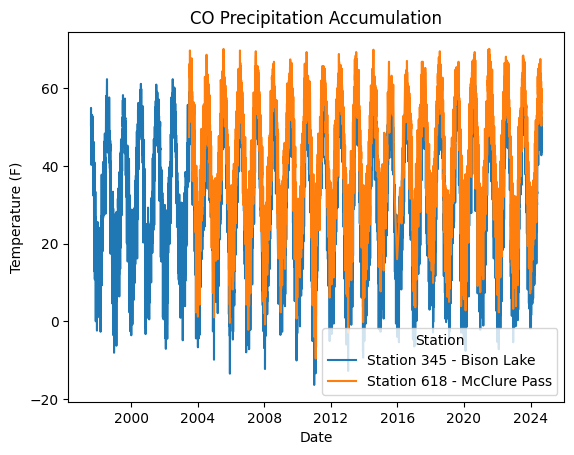

In [6]:
# Visualize Temp
sns.lineplot(data=df_final, x='date', y='TAVG', hue='Station', legend=True)
plt.title('CO Precipitation Accumulation')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

In [37]:
df_final['Station'] = (
    df_final['Station'].apply(
        lambda x: x
        .replace('Station 618 - ','')
        .replace('Station 345 - ','')
        .replace(' ', ''))
)

In [38]:
# Pivot dataset to make each station/var pair a feature
pivot_df = df_final.pivot(index="date", columns="Station")
pivot_df.columns = [f"{station}_{varname}" for station, varname in pivot_df.columns]
pivot_df = pivot_df.dropna()
display(pivot_df)

pivot_df.to_parquet('data/nrcs_swe_pivot.parquet', index=True)

,SNWD_BisonLake,SNWD_McClurePass,WTEQ_BisonLake,WTEQ_McClurePass,PREC_BisonLake,PREC_McClurePass,PRCP_BisonLake,PRCP_McClurePass,TAVG_BisonLake,TAVG_McClurePass,TMAX_BisonLake,TMAX_McClurePass,TMIN_BisonLake,TMIN_McClurePass
date,,,,,,,,,,,,,,
2003-06-25,0.0,0.0,0.0,0.0,35.1,26.0,0.2,0.0,36.0,47.5,47.1,61.3,28.4,35.8
2003-06-26,0.0,0.0,0.0,0.0,35.3,26.0,0.2,0.0,42.8,50.9,55.4,66.9,29.7,34.2
2003-06-27,0.0,0.0,0.0,0.0,35.3,26.1,0.0,0.1,48.4,56.1,59.4,70.0,35.8,42.4
2003-06-28,0.0,0.0,0.0,0.0,35.3,26.1,0.0,0.0,52.3,59.9,63.0,74.8,40.1,45.9
2003-06-29,0.0,0.0,0.0,0.0,35.3,26.1,0.0,0.0,51.8,59.4,61.7,72.5,41.0,47.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.0,0.0,0.0,0.0,36.9,32.4,0.0,0.1,50.9,57.6,61.2,71.4,40.3,44.2
2024-08-31,0.0,0.0,0.0,0.0,36.9,32.4,0.0,0.0,52.5,59.9,64.9,73.8,42.8,45.7
2024-09-01,0.0,0.0,0.0,0.0,36.9,32.4,0.0,0.0,50.5,57.9,64.4,72.1,41.0,49.5
